--- 
### Problem Statement.
A model  to predict whether a comment or sentence written on twitter  is positive , negative or neutral . 

---

### THE START


---

In [1]:
!pip install catboost
# !pip install plotly --upgrade
!pip install pyyaml==5.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np 
import pandas as pd
import os
import plotly.express as px
#For Preprocessing
import re   
import nltk 
# nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split
import seaborn as sns

#For data visualization
import matplotlib.pyplot as plt
%matplotlib inline

pd.options.plotting.backend = "plotly"

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [3]:
# stopwords.words('english')

In [4]:
#set seed for productivity of the project
SEED = 2021
def seed(SEED=SEED):
    np.random.seed = SEED
    os.environ['PYTHONHASHSEED'] = str(SEED)
    
seed()

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### ETL for the data..
 * Load data , analysis , perform some preprocessing etc


In [6]:
# read the dataset
twitter = pd.read_csv('/content/drive/MyDrive/twitter.csv')


In [7]:
# preview both
print("Twitter head")
display(twitter.head())
print()


Twitter head


,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [8]:
# check for nulls
display(twitter.isna().sum())
print("\n")

clean_text    4
category      7
dtype: int64

In [9]:
# lets drop the nulls in both dataset
twitter.dropna(axis=0, inplace=True)

In [10]:
# recheck if there are any other nulls
twitter.isna().sum()

clean_text    0
category      0
dtype: int64

In [11]:
# check category unique values
print(f"Unique in twitter are  {twitter['category'].unique()}")


Unique in twitter are  [-1.  0.  1.]


* The `category` column has 3 values:
        * 0 for a neutral sentiment
        * 1 for a  postive sentiment
        * -1 for a negative sentiment

In [12]:
# check the size of the two dataset
twitter.shape

(162969, 2)

In [13]:
# rename the  clean_text and clean_comment to text
twitter = twitter.rename(columns = {"clean_text":"text"})

In [14]:
# preview the data
twitter.head()

,text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [15]:
# add the two dataset together to get one merged dataset
df = twitter.copy()

In [16]:
# shuffle the dataset to make it mixed for both twitter and reddit
from sklearn.utils import shuffle
df = shuffle(df  , random_state=12345).reset_index(drop=True)

In [17]:
# preview the new dataset
df.tail(10)

,text,category
162959,advanis ticket katata shatrughan sinha narendr...,0.0
162960,modi his best tv9 enclave,1.0
162961,modi first time loksabha election larha tha ta...,1.0
162962,this all she understood that modi has addresse...,0.0
162963,secretly they also voted for modi,-1.0
162964,went the spot where dia dropped there pay load...,-1.0
162965,\npublic rally meerut police officials who are...,0.0
162966,kovind modi greet people rajasthan day via ind...,0.0
162967,please pronto,0.0
162968,kitne sharam baat only criticize some people a...,-1.0


In [18]:
# rename the category column to their respective values
# create a mapper
mapper = {
    -1:"negative",
    0:"neutral",
    1:"positive",
}
df['category'] = df['category'].map(mapper)


In [19]:
df.head()

,text,category
0,modi will emerge strong position mark mobius t...,positive
1,someone told pakmodi will busy with,positive
2,more reasons for bhakts vote for again,positive
3,but modi for india namo coming againu like not,neutral
4,completely agree the one who has the guts take...,positive


In [20]:
df.category.unique()

array(['positive', 'neutral', 'negative'], dtype=object)

### Overview of data through some graphs

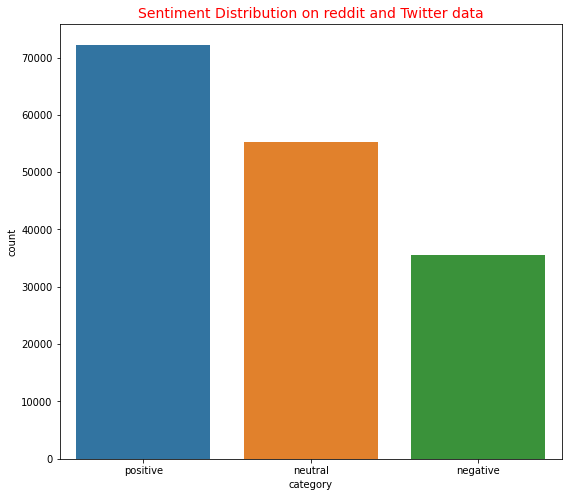

In [21]:
# check the distributions of the category column using a plot
plt.figure(figsize=(9,8))
sns.countplot(df.category)
plt.title("Sentiment Distribution on reddit and Twitter data" , c ="r" , fontsize =14)
plt.savefig("label.png")

* From the plot , sentiments that are positive were more compaired to others
* Negative sentiments were the lowest

In [22]:
# check the percentage for each sentiment
df.category.value_counts(normalize=1)

positive    0.443330
neutral     0.338782
negative    0.217888
Name: category, dtype: float64

In [23]:

fig = px.pie(df, names='category', title = 'Percentage for each sentiment in pie chart')
fig.show()



* Positive sentiments had about 44% , neutral about 34 and about 22 for negative sentiments

#### Remove stopwords

In [24]:
# remove stopwords from the text column
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
df.head()

,text,category
0,modi will emerge strong position mark mobius t...,positive
1,someone told pakmodi will busy with,positive
2,more reasons for bhakts vote for again,positive
3,but modi for india namo coming againu like not,neutral
4,completely agree the one who has the guts take...,positive


In [26]:
len(df.iloc[0]['text'].split()), len(df.iloc[0]['text'])

(25, 173)

* Plotting the distribution of text length for each sentiment tweets

In [27]:
def sentLengthPlot(sentiment , df , color , plot_name):
    fig = plt.figure(figsize=(10,7))
    df['length'] = df["text"].str.split().apply(len)
    ax1 = fig.add_subplot(122)
    sns.histplot(df[df['category']==sentiment]['length'], ax=ax1 , color =color)
    describe = df.length[df.category==sentiment].describe().to_frame().round(2)

    ax2 = fig.add_subplot(121)
    ax2.axis('off')
    font_size = 14
    bbox = [0, 0, 1, 1]
    table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
    table.set_fontsize(font_size)
    fig.suptitle(f'Distribution of text length for {sentiment} sentiment texts.', fontsize=14 , c ='r')
    plt.savefig(plot_name)
    plt.show()

### Plot the graphs for each sentiment

---

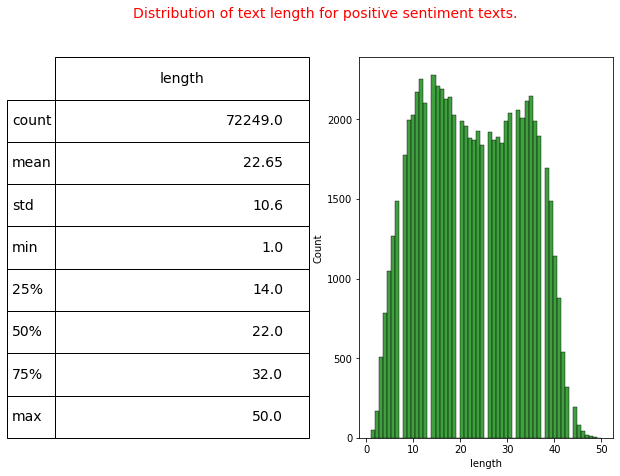

In [28]:
# for posive sentiment
sentLengthPlot("positive" , df , "green" , "positive.png")

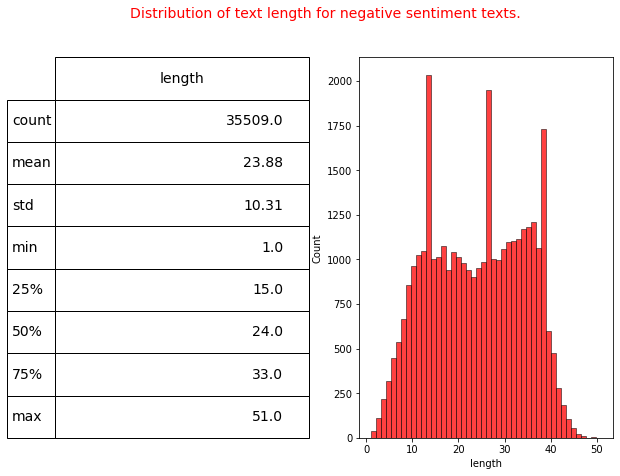

In [29]:
# for negative sentiment
sentLengthPlot("negative" , df , 'red' , "negative.png")

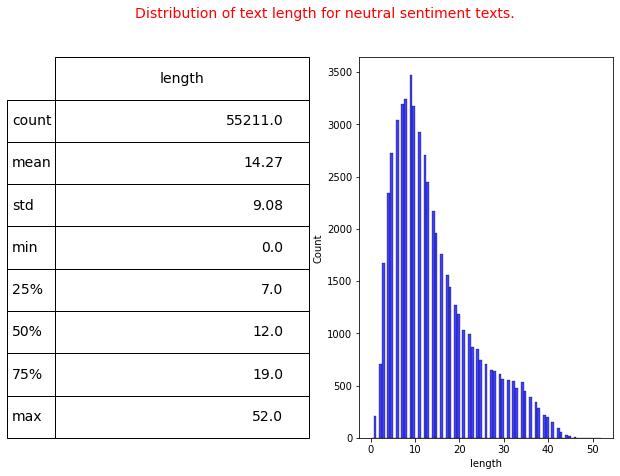

In [30]:
# for neutral sentiment
sentLengthPlot('neutral' , df ,'blue' , "neutal.png")

In [31]:
#  

In [32]:
#### check common words using wordcloud

from wordcloud import WordCloud, STOPWORDS

def wordcount_gen(df, category):
    """
    Function to get word clouds
    """
    # get all texts for the category together
    all_cat_text = " ".join([txt for txt in df[df.category==category]['text']])
                          
    # Initialize wordcloud object
    wc = WordCloud(background_color='white', 
                   max_words=50, 
                   stopwords = STOPWORDS)

    # Generate and plot wordcloud
    plt.figure(figsize=(10,10))
    plt.imshow(wc.generate(all_cat_text))
    plt.title(f'{category} Sentiment Words', fontsize=14 , c="r")
    plt.axis('off')
    plt.savefig(f"{category}Wordcloud.png")
    plt.show()
    

### PLot Wordcloud

---

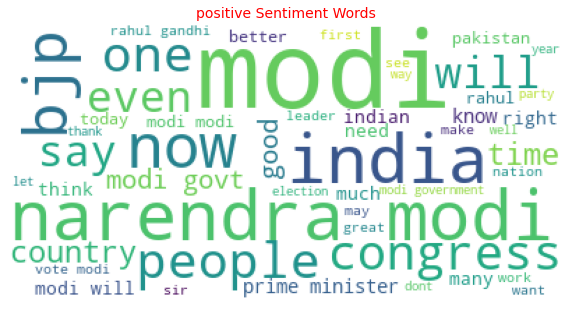

In [33]:
# for Positive texts
wordcount_gen(df, 'positive')

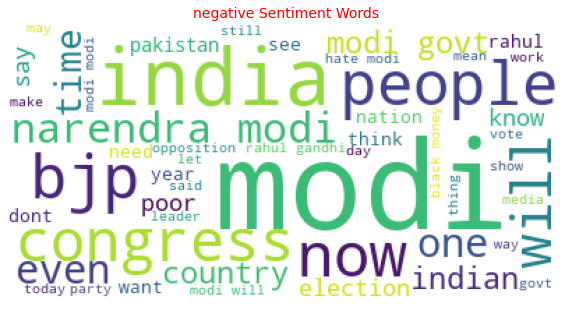

In [34]:
# for negative words
wordcount_gen(df, 'negative')

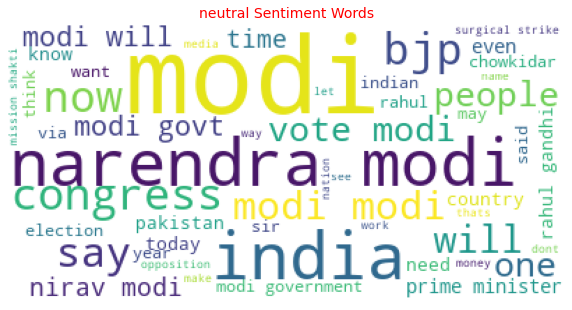

In [35]:
# for neutral words
wordcount_gen(df, 'neutral')


## Data Preprocessing


----

In [36]:
def CleanAndProcess(text):
    """
    This function removes any stopwords in the text
    It also removes punctuations
    and lastly it stemmize the word into its root form
    """
    
    # convert to lowercase
    text = text.lower()
    # remove non letters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    
    # tokenize the text into words
    words = text.split()
    # remove stopwords
    words = [w for w in words if w not in stopwords]
    # apply stemming
    words = [PorterStemmer().stem(w) for w in words]
    # return a new sentense with the applied functions
    return " ".join(words)



# check sample
print("Original text :  ", df['text'][10100])
print("\nProcessed text :  ", CleanAndProcess(df['text'][10100]))

Original text :   many modi critics are saying that real issues such joblessness agrarian crises manufacturing segment etc are not being discussed ⁠ ⁠ opinion the real issue about who can provide strong and honest leadership for sabka saath sabka vikas

Processed text :   mani modi critic say real issu jobless agrarian crise manufactur segment etc discuss opinion real issu provid strong honest leadership sabka saath sabka vika


In [37]:
# apply the function for processing and get the X features
X = df['text'].apply(CleanAndProcess)

In [38]:
# counter for most common
from collections import Counter
def counter(comment_clear):
    cnt = Counter()
    for words in comment_clear:
        for word in words.split():
            cnt[word] += 1
    return cnt


In [39]:
# /apply the count function
counts  = counter(X)


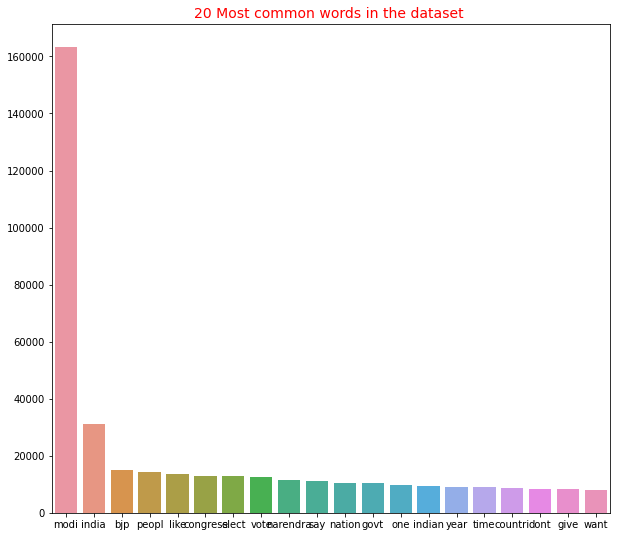

In [40]:
# plot the top 20 common words
top_20_words = []
top_20_count =[]
for word , count in counts.most_common(20):
    top_20_words.append(word)
    top_20_count.append(count)
    
plt.figure(figsize=(10 ,9))
plt.title("20 Most common words in the dataset " , c ="r" , fontsize=14)
sns.barplot(top_20_words , top_20_count)
plt.savefig("20mostcommon.png")

### Processing the labels and Text for machine learning

In [41]:
from sklearn.preprocessing import LabelEncoder
# re - encode the categories to numerical
encoder = LabelEncoder()
encoder.fit(df['category'])

label = encoder.transform(df['category'])

In [42]:
label

array([2, 2, 2, ..., 1, 1, 0])

In [43]:
encoder.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

In [44]:
encoder.inverse_transform(label)

array(['positive', 'positive', 'positive', ..., 'neutral', 'neutral',
       'negative'], dtype=object)

In [45]:
# encoder.get_params()

In [46]:
# split the text to get training and testing datasets


### Spliting for Train and test 

In [47]:
# split into train and test with 85% train and 15% test
X_train, X_test, y_train, y_test = train_test_split(
    X, label, 
    test_size=0.15, 
    random_state=SEED)


In [48]:
# check the new sizes
X_train.shape , y_train.shape , X_test.shape , y_test.shape

((138523,), (138523,), (24446,), (24446,))

In [49]:
# TF - term frequency.
# IDF - Appearance in the whole docs

### Feature extraction

* We will use bag of words and also TDIFVectorizer(which frequency of word) to extract text features

---

In [50]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


# define vectorizers
# count vectorizer
countVect = CountVectorizer() 
# frequency vectorizer.
tfidfVect = TfidfVectorizer()

# fit count vectorizer
countVect.fit(X)
# fit tdifvector
tfidfVect.fit(X)

TfidfVectorizer()

In [51]:
# transform the training to vects
X_train_count = countVect.transform(X_train)
X_train_tdfif = tfidfVect.transform(X_train)

# transform the testing data
X_test_tdfif = tfidfVect.transform(X_test)
X_test_count = countVect.transform(X_test)

### Modelling.

* We will be using simple traditional algorithms to create the model and one Boosting algorithm

In [52]:
from sklearn.naive_bayes import MultinomialNB , GaussianNB
from sklearn.linear_model import LogisticRegression 
from catboost import CatBoostClassifier
from xgboost import XGBRFClassifier, XGBClassifier
from lightgbm import LGBMClassifier

In [53]:
# define logistic model
logit_count = LogisticRegression()

# create the random forest model
nb =MultinomialNB()

# define catboost model
cat =CatBoostClassifier(n_estimators =50 , verbose=0)


In [54]:
# train and get score for each.
logit_count.fit(X_train_count , y_train)
print(f"Logistic reg score is  {logit_count.score(X_test_count , y_test)}")

# train random forest
nb.fit(X_train_count,y_train)
print(f"Multinomial NB score is  {nb.score(X_test_count , y_test)}")

# train XGBOOST model
cat.fit(X_train_count,y_train)
print(f"CatNoost CLassifier score is  {cat.score(X_test_count , y_test)}")

Logistic reg score is  0.8526957375439744
Multinomial NB score is  0.7071913605497832
CatNoost CLassifier score is  0.8011126564673157


* Logistic Regression was selected with  count vectorizers since it had highest score.

### MODEL HYPERPARAMETER  TUNING

---

* We will be using Logistic regression as the baseline model .
* Try to tuning logistic regression and XGBOOSt as they had a better score with the use gridsearchcv to tune hyperparameters.
* All models will be then evaluated using F1 score, Recall, and Precision and then draw confusion matrix

In [55]:
# create a function to draw confusion matrix and showing the model statistics
# confussion matrix plot
# define the parameters to be tuned 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score , confusion_matrix , classification_report , f1_score, recall_score, precision_score

def show_model_stats(model_name , Model , x_test , y_test):
    # get prdictions
    print(f"\t\t********** {Model}  Evaluation **********\n")
    prediction = model_name.predict(x_test)
    print(f"Accuracy is   {accuracy_score(y_test , prediction)*100}%")
    print(f"F1 Score is   {f1_score(y_test , prediction , average='weighted')*100}%")
    print(f"Recall Score is   {recall_score(y_test , prediction , average='weighted')*100}%")
    print(f"Precision Score is   {precision_score(y_test , prediction , average='weighted')*100}%\n")
    # classifciation reports
    print(classification_report(y_test, prediction))
    print("\n")
    c_matrix = confusion_matrix(y_test, prediction)
    # plot confusion matrix for better view
    plt.figure(figsize=(9,9))
    sns.heatmap(c_matrix , annot= True ,fmt="" ,  annot_kws={"size": 10})
    plt.xlabel("Actual Label")
    plt.ylabel("Predicted Label")
    plt.title(f"Confusion Matrix Plot for {Model} classifier")

		********** Tuned Logistic Regression  Evaluation **********

Accuracy is   85.26957375439744%
F1 Score is   85.19315529929142%
Recall Score is   85.26957375439744%
Precision Score is   85.28223602069583%

              precision    recall  f1-score   support

           0       0.81      0.75      0.78      5458
           1       0.84      0.91      0.87      8067
           2       0.88      0.86      0.87     10921

    accuracy                           0.85     24446
   macro avg       0.85      0.84      0.84     24446
weighted avg       0.85      0.85      0.85     24446





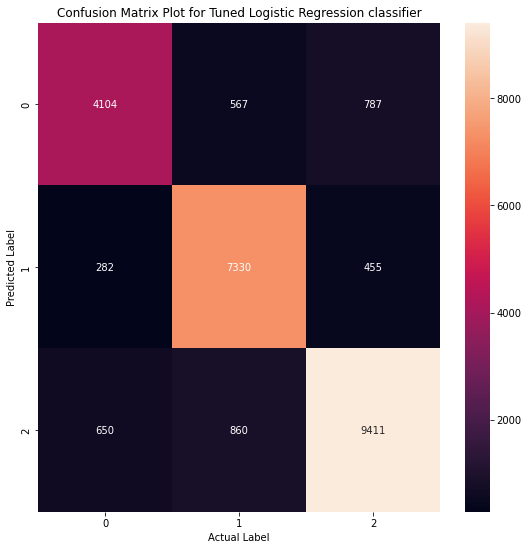

In [56]:
# logistic regression parameter tuning

best_logic_params = {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
# train model using the best params
logistic = LogisticRegression(**best_logic_params)
logistic.fit(X_train_count,y_train)

# evaluate the model
show_model_stats(logistic , "Tuned Logistic Regression" , X_test_count , y_test)
plt.savefig("log.png")

		********** Tuned Catboost  Evaluation **********

Accuracy is   80.11126564673157%
F1 Score is   79.78516987032638%
Recall Score is   80.11126564673157%
Precision Score is   81.5392235299568%

              precision    recall  f1-score   support

           0       0.84      0.60      0.70      5458
           1       0.72      0.94      0.81      8067
           2       0.88      0.80      0.84     10921

    accuracy                           0.80     24446
   macro avg       0.81      0.78      0.78     24446
weighted avg       0.82      0.80      0.80     24446





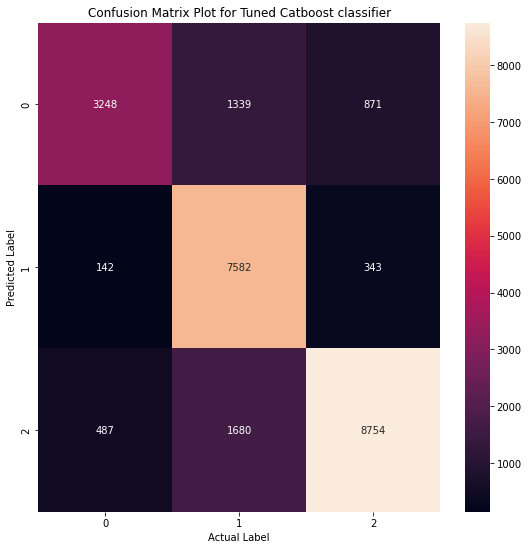

In [57]:
# define models and parameters
tuned_cat_params={
     "n_estimators": 50, "verbose":0
}

cat =CatBoostClassifier(**tuned_cat_params)
cat.fit(X_train_count,y_train)
# evaluate the tuned model
show_model_stats(cat , "Tuned Catboost" , X_test_count , y_test)
plt.savefig("cat.png")

		********** Tuned MultinomialNB  Evaluation **********

Accuracy is   71.2468297471979%
F1 Score is   70.87544417022669%
Recall Score is   71.2468297471979%
Precision Score is   72.09862563992921%

              precision    recall  f1-score   support

           0       0.67      0.60      0.63      5458
           1       0.80      0.61      0.70      8067
           2       0.69      0.84      0.76     10921

    accuracy                           0.71     24446
   macro avg       0.72      0.69      0.70     24446
weighted avg       0.72      0.71      0.71     24446





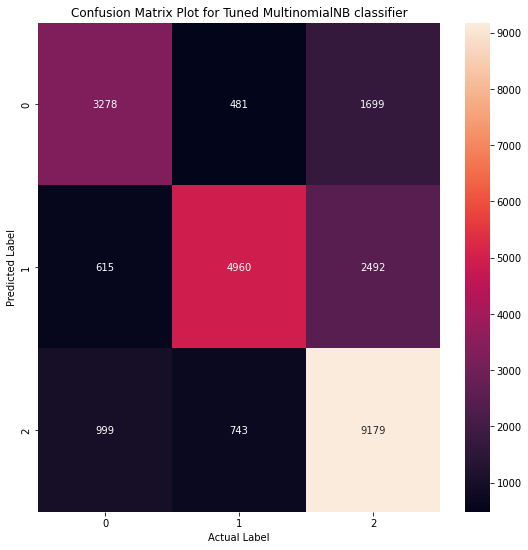

In [58]:
# multinomialNB
nb_params = {'alpha':0.8,
        }

nb = MultinomialNB(**nb_params)
nb.fit(X_train_count,y_train)
# evaluate the model
show_model_stats(nb , "Tuned MultinomialNB" , X_test_count , y_test)
plt.savefig("nb.png")

In [59]:
#################### END TUNE PARAMETERS######################

---

THE DEEP LEARNING.


1. LSTM
- We are going to design a ANN using lstm and process the data for the same
--- 

In [60]:
# import tensorflow tokenizer and layers for model architecture
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [61]:
# sample processed data
X

0         modi emerg strong posit mark mobiu founder eme...
1                                  someon told pakmodi busi
2                                         reason bhakt vote
3                          modi india namo come againu like
4         complet agre one gut take blame case someth go...
                                ...                        
162964    went spot dia drop pay load swear big isra bom...
162965    public ralli meerut polic offici involv secur ...
162966    kovind modi greet peopl rajasthan day via inde...
162967                                         pleas pronto
162968    kitn sharam baat critic peopl becom worst citi...
Name: text, Length: 162969, dtype: object

In [62]:
X.shape

(162969,)

In [63]:
# lets select randomly 30k data
new_df = pd.DataFrame()
new_df["text"] = X
new_df['label'] = label

selected_data = new_df.sample(30000)
X = selected_data['text']
label = selected_data['label']

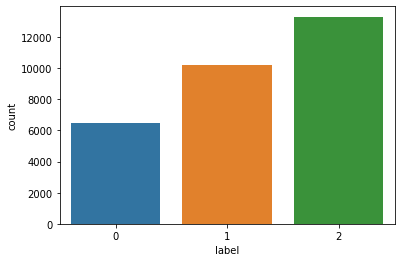

In [64]:
# check distribution of target
sns.countplot(label)

In [65]:
label.shape, X.shape

((30000,), (30000,))

In [66]:
# max number of words to be used in this case
MAX_NB_WORDS = 30000

# max number of words in each record
MAX_SEQUENCE_LENGTH = df['text'].apply(len).max() -124

# dimesnion of the embedding layer
EMBEDDING_DIM = 64

In [67]:
# create a tokenizer object to be used to tokenizer texts
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower =True)

In [68]:
# train the tokenizer with the Data
tokenizer.fit_on_texts(X.values)

# get indexes
word_index = tokenizer.word_index

# number of unique tokens identifies
print(f"Found  {len(word_index)} unique tokens")

Found  29797 unique tokens


In [69]:
# convert the data into vectors using the tokenizer
X_tokenized = tokenizer.texts_to_sequences(X.values)

# pad sentenses into similar size
X_tokenized = pad_sequences(X_tokenized, maxlen=MAX_SEQUENCE_LENGTH)

In [70]:
# check shape of the new data
X_tokenized.shape

(30000, 150)

In [71]:
# split into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X_tokenized,to_categorical(label), test_size = 0.2, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(24000, 150) (24000, 3)
(6000, 150) (6000, 3)


In [72]:
# define a simple model architecture of lstm to be used
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_tokenized.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))

In [73]:
# compile the model using accuracy as the mean of compairing and categorical cross entropy as loss
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 64)           1920000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 150, 64)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               66000     
                                                                 
 dense (Dense)               (None, 64)                6464      
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 1,992,659
Trainable params: 1,992,659
Non-trainable params: 0
______________________________________________

In [74]:
# train the model
epochs = 64
batch_size = 240

history = model.fit(
    X_train, Y_train, 
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.3,
    callbacks=[EarlyStopping(monitor='val_loss', patience=30, min_delta=0.0001)]
    )

Epoch 1/64
70/70 [==============================] - 25s 313ms/step - loss: 0.9831 - accuracy: 0.5324 - val_loss: 0.8922 - val_accuracy: 0.5811
Epoch 2/64
70/70 [==============================] - 21s 307ms/step - loss: 0.6698 - accuracy: 0.7096 - val_loss: 0.6115 - val_accuracy: 0.7600
Epoch 3/64
70/70 [==============================] - 21s 307ms/step - loss: 0.3820 - accuracy: 0.8619 - val_loss: 0.5724 - val_accuracy: 0.7832
Epoch 4/64
70/70 [==============================] - 22s 311ms/step - loss: 0.2535 - accuracy: 0.9151 - val_loss: 0.6380 - val_accuracy: 0.7886
Epoch 5/64
70/70 [==============================] - 23s 321ms/step - loss: 0.1936 - accuracy: 0.9361 - val_loss: 0.6812 - val_accuracy: 0.7815
Epoch 6/64
70/70 [==============================] - 22s 311ms/step - loss: 0.1547 - accuracy: 0.9498 - val_loss: 0.7390 - val_accuracy: 0.7806
Epoch 7/64
70/70 [==============================] - 22s 313ms/step - loss: 0.1292 - accuracy: 0.9584 - val_loss: 0.8098 - val_accuracy: 0.7719

In [75]:
# evaluate the model
model.evaluate(X_test, Y_test)

188/188 [==============================] - 8s 42ms/step - loss: 1.7590 - accuracy: 0.7417


[1.7589770555496216, 0.7416666746139526]

In [76]:
# function to draw   confusion matrix plot and other test stats
# define function to plot results
def drawConfusionMatrix(model_name , Model, x_test, y_test):
    # get prdictions
    print(f"\t\t********** {Model}  Evaluation **********\n\n")
    from sklearn.metrics import accuracy_score , confusion_matrix , classification_report
    prediction = model_name.predict(x_test)
    # get the max predicted output
    prediction = np.argmax(prediction, axis=1)
    y_test = np.argmax(y_test, axis=1)
    print(f"Accuracy is   {accuracy_score(y_test , prediction)*100}%\n\n")
    # classifciation reports
    print(classification_report(y_test, prediction))
    print("\n\n")
    c_matrix = confusion_matrix(y_test, prediction)
    # plot confusion matrix for better view
    plt.figure(figsize=(4,4))
    sns.heatmap(c_matrix , annot= True ,fmt="" ,  annot_kws={"size": 10})
    plt.xlabel("Actual Label")
    plt.ylabel("Predicted Label")
    plt.title(f"Confusion Matrix Plot for {Model} classifier")
    plt.savefig(f"{Model}.png")
    

		********** LSTM Model  Evaluation **********


Accuracy is   74.16666666666667%


              precision    recall  f1-score   support

           0       0.64      0.63      0.64      1297
           1       0.76      0.76      0.76      2076
           2       0.78      0.78      0.78      2627

    accuracy                           0.74      6000
   macro avg       0.73      0.72      0.73      6000
weighted avg       0.74      0.74      0.74      6000






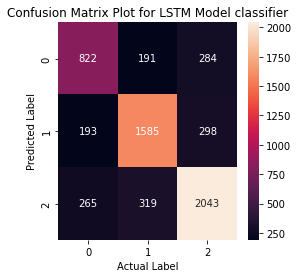

In [77]:
drawConfusionMatrix(model, "LSTM Model", X_test, Y_test)

In [78]:
# function to draw plots
# plots the losses and accuracies trends
def create_review_plots(history , model_name):    
    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    plt.title(f"\t\t***********{model_name} Evaluation Plots *************")
    #plot accuracies
    axes[0].plot(history.history['accuracy'] , label ="trainning accuracy" )
    axes[0].plot(history.history['val_accuracy'], label = "validation accuracy")
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend(['Accuracy Train','Accuracy Test'])
    axes[0].grid(True)
    
    #plot losses
    axes[1].plot(history.history['loss'] , label="trainning loss")
    axes[1].plot(history.history['val_loss'] , label="validation loss")
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Error')
    axes[1].legend(['Error Train','Error Test'])
    axes[1].grid(True)
    axes[1].set_title(f"{model_name} Model Loss Evaluation " , c ='red' , fontsize =15)
    axes[0].set_title(f"{model_name} Model Accuracy Evaluation " , c ='red' , fontsize =15)

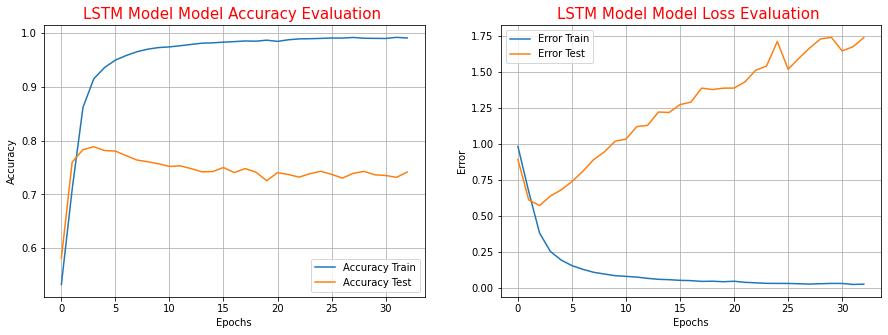

In [79]:
create_review_plots(history, "LSTM Model")

### BERT model

- Model will be developed with pretrained model

In [80]:
!pip install transformers
import transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [81]:
# import tokenizer and model
from transformers import DistilBertTokenizerFast
from transformers import TFDistilBertForSequenceClassification, TFDistilBertModel
import tensorflow as tf


In [82]:
# split into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X,label, test_size = 0.2, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(24000,) (24000,)
(6000,) (6000,)


In [83]:
# initialize the tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [84]:
# tokenize a sample data
tokenizer([X_train.iloc[0]], truncation=True,
                            padding=True, max_length=128)

{'input_ids': [[101, 6583, 7389, 7265, 16913, 2072, 2293, 2757, 8945, 4305, 8254, 2278, 2526, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [85]:
# check smaple sentences
tokenizer.tokenize(X_test.iloc[32])

['100th',
 'sc',
 '##am',
 'mod',
 '##i',
 'cho',
 '##r',
 'gujarat',
 'water',
 'su',
 '##pp',
 '##li',
 'se',
 '##wa',
 '##g',
 'board',
 'sc',
 '##am',
 'come',
 'light',
 'ex',
 '##pen',
 '##s',
 'worth',
 'rs',
 '##34',
 '##0',
 '##cr',
 'list',
 'per',
 'account',
 'standard']

In [86]:

def tokenize(sentences, max_length=MAX_SEQUENCE_LENGTH, padding='max_length'):
    return tokenizer(
        sentences,
        truncation=True,
        padding=padding,
        max_length=max_length,
        return_tensors="tf"
    )

In [87]:
# Inputs for token indices and attention masks
input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='attention_mask')

In [88]:
# download and define the bert model

# we have 3 labels so we pass them
NUM_LABELS = 3
bert_model = TFDistilBertModel.from_pretrained(
    "distilbert-base-uncased",
    num_labels=NUM_LABELS
)


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_projector', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [89]:

# Freeze the base model weights.

for layer in bert_model.layers:
    layer.trainable = False

bert_model.summary()



Model: "tf_distil_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
Total params: 66,362,880
Trainable params: 0
Non-trainable params: 66,362,880
_________________________________________________________________


In [90]:
# [CLS] embedding is last_hidden_state[:, 0, :]
output = bert_model([input_ids, attention_mask]).last_hidden_state[:, 0, :]

In [91]:
NUM_BASE_MODEL_OUTPUT = 768
L2 = 0.01
# customizer the head of the model
# -------------------------------------------------------------------------------
# Classifiation leayer 01
# --------------------------------------------------------------------------------
# output = tf.keras.layers.Dropout(
#     rate=0.15,
#     name="01_dropout",
# )(output)

# output = tf.keras.layers.Dense(
#     units=NUM_BASE_MODEL_OUTPUT,
#     kernel_initializer='glorot_uniform',
#     activation=None,
#     name="01_dense_relu_no_regularizer",
# )(output)
# output = tf.keras.layers.BatchNormalization(
#     name="01_bn"
# )(output)
# output = tf.keras.layers.Activation(
#     "relu",
#     name="01_relu"
# )(output)

# --------------------------------------------------------------------------------
# Classifiation leayer 02
# --------------------------------------------------------------------------------
# output = tf.keras.layers.Dense(
#     units=NUM_BASE_MODEL_OUTPUT,
#     kernel_initializer='glorot_uniform',
#     activation=None,
#     name="02_dense_relu_no_regularizer",
# )(output)
# output = tf.keras.layers.BatchNormalization(
#     name="02_bn"
# )(output)
# output = tf.keras.layers.Activation(
#     "relu",
#     name="02_relu"
# )(output)


# final layer using softmax

# --------------------------------------------------------------------------------
# Final Layer OUTPUT leayer 03
# --------------------------------------------------------------------------------

output = bert_model([input_ids, attention_mask]).last_hidden_state[:, 0, :]
output = tf.keras.layers.Dense(
    units=NUM_LABELS,
    kernel_initializer='glorot_uniform',
    kernel_regularizer=tf.keras.regularizers.l2(l2=L2),
    activation='softmax',
    name="softmax"
)(output)

In [92]:
LEARNING_RATE = 1e-2
model = tf.keras.models.Model(inputs=[input_ids, attention_mask], outputs=output, name="Custom_Bert")
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    metrics=['accuracy']
)
model.summary()

Model: "Custom_Bert"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 150)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 150)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 BertModel)                     ast_hidden_state=(N               'attention_mask[0][0]']         
                                one, 150, 768),                                                   
                                 hidden_states=None                                     

In [93]:
BATCH_SIZE=64
X = tf.data.Dataset.from_tensor_slices((
    dict(tokenize(X_train.tolist())),  # Convert BatchEncoding instance to dictionary
    Y_train
)).batch(BATCH_SIZE).prefetch(1)

V = tf.data.Dataset.from_tensor_slices((
    dict(tokenize(X_test.tolist())),  # Convert BatchEncoding instance to dictionary
    Y_test
)).batch(BATCH_SIZE).prefetch(1)

In [94]:

# --------------------------------------------------------------------------------
NUM_EPOCHS =25
history = model.fit(
    x=X,    # dictionary 
    # y=Y,
    y=None,
    epochs=NUM_EPOCHS,
    batch_size=320,#BATCH_SIZE,
    validation_data=V,
)

Epoch 1/25
375/375 [==============================] - 178s 437ms/step - loss: 1.0016 - accuracy: 0.5407 - val_loss: 0.9384 - val_accuracy: 0.5780
Epoch 2/25
375/375 [==============================] - 162s 432ms/step - loss: 0.9835 - accuracy: 0.5510 - val_loss: 0.9412 - val_accuracy: 0.5763
Epoch 3/25
375/375 [==============================] - 161s 428ms/step - loss: 0.9820 - accuracy: 0.5506 - val_loss: 0.9381 - val_accuracy: 0.5792
Epoch 4/25
375/375 [==============================] - 162s 432ms/step - loss: 0.9817 - accuracy: 0.5498 - val_loss: 0.9384 - val_accuracy: 0.5782
Epoch 5/25
375/375 [==============================] - 162s 432ms/step - loss: 0.9852 - accuracy: 0.5493 - val_loss: 0.9415 - val_accuracy: 0.5752
Epoch 6/25
375/375 [==============================] - 161s 429ms/step - loss: 0.9824 - accuracy: 0.5499 - val_loss: 0.9390 - val_accuracy: 0.5818
Epoch 7/25
375/375 [==============================] - 160s 428ms/step - loss: 0.9815 - accuracy: 0.5518 - val_loss: 0.9402 -

In [95]:
model.evaluate(V)

94/94 [==============================] - 31s 327ms/step - loss: 0.9402 - accuracy: 0.5790


[0.9402468800544739, 0.5789999961853027]

In [101]:
model.predict(V)

array([[0.31197402, 0.5205423 , 0.16748372],
       [0.06232534, 0.76768297, 0.16999166],
       [0.25214857, 0.5663763 , 0.18147509],
       ...,
       [0.16942617, 0.6179746 , 0.21259926],
       [0.1717863 , 0.5692148 , 0.25899887],
       [0.4168528 , 0.3830704 , 0.20007686]], dtype=float32)

		********** BERT  Evaluation **********


Accuracy is   57.9%


              precision    recall  f1-score   support

           0       0.50      0.24      0.33      1297
           1       0.56      0.72      0.63      2076
           2       0.61      0.63      0.62      2627

    accuracy                           0.58      6000
   macro avg       0.56      0.53      0.53      6000
weighted avg       0.57      0.58      0.56      6000






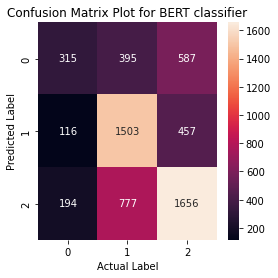

In [108]:
# get prdictions
print(f"\t\t********** BERT  Evaluation **********\n\n")
# predict labels fot the test dataset
prediction = model.predict(V)
# get the max predicted output
prediction = np.argmax(prediction, axis=1)
y_test = Y_test
print(f"Accuracy is   {accuracy_score(y_test , prediction)*100}%\n\n")
# classifciation reports
print(classification_report(y_test, prediction))
print("\n\n")
c_matrix = confusion_matrix(y_test, prediction)
# plot confusion matrix for better view
plt.figure(figsize=(4,4))
sns.heatmap(c_matrix , annot= True ,fmt="" ,  annot_kws={"size": 10})
plt.xlabel("Actual Label")
plt.ylabel("Predicted Label")
plt.title(f"Confusion Matrix Plot for BERT classifier")
plt.savefig(f"BERT.png")

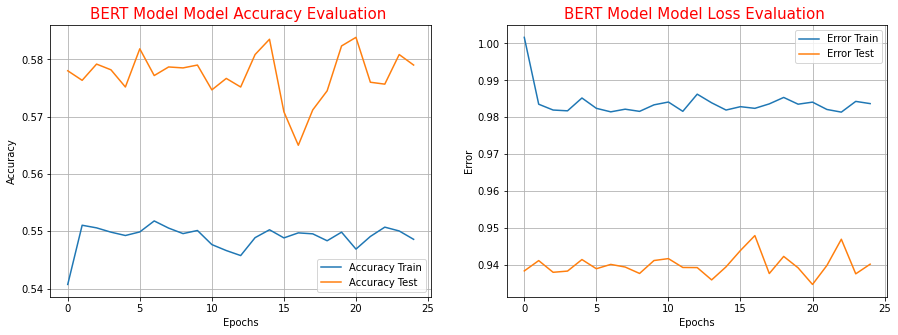

In [105]:
create_review_plots(history, "BERT Model")

In [106]:
# # test
model.predict(dict(tokenize(["Hello world is a first world that every programmer yearns to print out on the screen"])))

array([[0.05578693, 0.7505988 , 0.19361435]], dtype=float32)

## THE END....

---